# Yelp data analysis

## Creating helper functions


In [1]:
import json
import pandas as pd

# A function to explore the first few rows of a json file

def head_json(filename, n=5):
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            if i >= n:
                break
            print(json.loads(line))

head_json('../data/raw/yelp_academic_dataset_business.json')


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/kristinakogan/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/kristinakogan/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/kristinakogan/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/kristinakogan/.pyenv/versions/3.10.6/envs/lewagon/lib/pyth

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/kristinakogan/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/kristinakogan/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/kristinakogan/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/kristinakogan/.pyenv/versions/3.10.6/envs/lewagon/lib/pyth

AttributeError: _ARRAY_API not found

{'business_id': 'Pns2l4eNsfO8kk83dixA6A', 'name': 'Abby Rappoport, LAC, CMQ', 'address': '1616 Chapala St, Ste 2', 'city': 'Santa Barbara', 'state': 'CA', 'postal_code': '93101', 'latitude': 34.4266787, 'longitude': -119.7111968, 'stars': 5.0, 'review_count': 7, 'is_open': 0, 'attributes': {'ByAppointmentOnly': 'True'}, 'categories': 'Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists', 'hours': None}
{'business_id': 'mpf3x-BjTdTEA3yCZrAYPw', 'name': 'The UPS Store', 'address': '87 Grasso Plaza Shopping Center', 'city': 'Affton', 'state': 'MO', 'postal_code': '63123', 'latitude': 38.551126, 'longitude': -90.335695, 'stars': 3.0, 'review_count': 15, 'is_open': 1, 'attributes': {'BusinessAcceptsCreditCards': 'True'}, 'categories': 'Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services', 'hours': {'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', 'Wednesday': '8:0-18:30', 'Thursday': '8:0-18:30', 'Friday': '8:0-18

 ## Count of the total number of rows (businesses)

In [2]:
with open('../data/raw/yelp_academic_dataset_business.json', 'r') as f:
    total = sum(1 for line in f)
print(f"Total businesses: {total}")

Total businesses: 150346


## Checking which cities are represented in the dataset

In [5]:
def extract_all_businesses(filename):
    """Extract all business data for later use"""
    businesses = []
    
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            biz = json.loads(line)
            businesses.append({
                'business_id': biz['business_id'],
                'name': biz['name'],
                'city': biz.get('city'),
                'state': biz.get('state'),
                'postal_code': biz.get('postal_code'),
                'latitude': biz.get('latitude'),
                'longitude': biz.get('longitude'),
                'stars': biz.get('stars'),
                'review_count': biz.get('review_count'),
                'is_open': biz.get('is_open'),
                'categories': biz.get('categories', '')
            })
            
            if (i + 1) % 50000 == 0:
                print(f"Processed {i + 1} businesses...")
    
    df = pd.DataFrame(businesses)
    print(f"\nTotal businesses loaded: {len(df):,}")
    
    # Save to CSV for easy reuse
    df.to_csv('all_businesses.csv', index=False)
    print("Saved to 'all_businesses.csv'")
    
    return df

# Run it
df_business = extract_all_businesses('../data/raw/yelp_academic_dataset_business.json')

# Quick analysis
print(f"Unique cities: {df_business['city'].nunique()}")
print(f"Unique states: {df_business['state'].nunique()}")
print("\nTop 20 cities by business count:")
print(df_business['city'].value_counts().head(20))

Processed 50000 businesses...
Processed 100000 businesses...
Processed 150000 businesses...

Total businesses loaded: 150,346
Saved to 'all_businesses.csv'
Unique cities: 1416
Unique states: 27

Top 20 cities by business count:
city
Philadelphia        14569
Tucson               9250
Tampa                9050
Indianapolis         7540
Nashville            6971
New Orleans          6209
Reno                 5935
Edmonton             5054
Saint Louis          4827
Santa Barbara        3829
Boise                2937
Clearwater           2221
Saint Petersburg     1663
Metairie             1643
Sparks               1624
Wilmington           1446
Franklin             1414
St. Louis            1255
St. Petersburg       1185
Meridian             1043
Name: count, dtype: int64


### What categories exist in the dataset?

In [11]:

# Load your business data
df_business = pd.read_csv('all_businesses.csv')

# Extract all unique categories
all_categories = []

for categories_str in df_business['categories'].dropna():
    # Split by comma (categories are stored as "Mexican, Burgers, Gastropubs")
    categories = [cat.strip() for cat in str(categories_str).split(',')]
    all_categories.extend(categories)

# Count them
category_counts = Counter(all_categories)

print(f"Total unique categories: {len(category_counts)}")
print("\nTop 20 most common categories:")
for i, (category, count) in enumerate(category_counts.most_common(20), 1):
    print(f"{i:2d}. {category:40s} {count:6,} businesses")

# Save for reference
category_df = pd.DataFrame(category_counts.most_common(), 
                          columns=['category', 'business_count'])
category_df.to_csv('all_categories.csv', index=False)

Total unique categories: 1311

Top 20 most common categories:
 1. Restaurants                              52,268 businesses
 2. Food                                     27,781 businesses
 3. Shopping                                 24,395 businesses
 4. Home Services                            14,356 businesses
 5. Beauty & Spas                            14,292 businesses
 6. Nightlife                                12,281 businesses
 7. Health & Medical                         11,890 businesses
 8. Local Services                           11,198 businesses
 9. Bars                                     11,065 businesses
10. Automotive                               10,773 businesses
11. Event Planning & Services                 9,895 businesses
12. Sandwiches                                8,366 businesses
13. American (Traditional)                    8,139 businesses
14. Active Life                               7,687 businesses
15. Pizza                                     7,093 busi

In [13]:

def filter_by_city_and_category(df, city, state, category):
    """
    Filter businesses by city, state, and category
    
    Parameters:
    - df: DataFrame with business data
    - city: city name (e.g., 'Philadelphia')
    - state: state code (e.g., 'PA')
    - category: category to search for (e.g., 'Restaurants')
    
    Returns:
    - Filtered DataFrame
    """
    # Filter by city and state
    df_city = df[(df['city'] == city) & (df['state'] == state)].copy()
    
    # Filter by category
    def has_category(categories_str):
        if pd.isna(categories_str):
            return False
        # Split and check if target category is in the list
        cats = [cat.strip() for cat in str(categories_str).split(',')]
        return category in cats
    
    df_filtered = df_city[df_city['categories'].apply(has_category)].copy()
    
    return df_filtered

# Use the function for Philadelphia
print("="*70)
print("PHILADELPHIA RESTAURANTS")
print("="*70)
df_philly_restaurants = filter_by_city_and_category(
    df_business, 
    'Philadelphia', 
    'PA', 
    'Restaurants'
)
print(f"Found: {len(df_philly_restaurants)} businesses")
print(f"Total reviews: {df_philly_restaurants['review_count'].sum():,}")
print("\nSample:")
print(df_philly_restaurants[['name', 'stars', 'review_count']].head(10))

print("\n" + "="*70)
print("PHILADELPHIA HOTELS & TRAVEL")
print("="*70)
df_philly_hotels = filter_by_city_and_category(
    df_business, 
    'Philadelphia', 
    'PA', 
    'Hotels & Travel'
)
print(f"Found: {len(df_philly_hotels)} businesses")
print(f"Total reviews: {df_philly_hotels['review_count'].sum():,}")
print("\nSample:")
print(df_philly_hotels[['name', 'stars', 'review_count']].head(10))

# Combined summary
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"Restaurants: {len(df_philly_restaurants)} businesses")
print(f"Hotels & Travel: {len(df_philly_hotels)} businesses")
print(f"Total: {len(df_philly_restaurants) + len(df_philly_hotels)} businesses")

PHILADELPHIA RESTAURANTS
Found: 5852 businesses
Total reviews: 665,732

Sample:
                                    name  stars  review_count
3                     St Honore Pastries    4.0            80
15                              Tuna Bar    4.0           245
19                                   BAP    4.5           205
28                               Bar One    4.0            65
31                      DeSandro on Main    3.0            41
35                            Craft Hall    3.5            65
82                                  Wawa    3.0            56
130  Golden Chopstick Chinese Restaurant    3.0           137
151                              J Sushi    4.5            72
199                              Wendy's    1.5            15

PHILADELPHIA HOTELS & TRAVEL
Found: 392 businesses
Total reviews: 28,982

Sample:
                                   name  stars  review_count
143              David Thomas Trailways    4.5             6
246   Watson Adventures Scavenger

In [15]:
# Use the same function for New Orleans
print("="*70)
print("NEW ORLEANS RESTAURANTS")
print("="*70)
df_nola_restaurants = filter_by_city_and_category(
    df_business, 
    'New Orleans', 
    'LA', 
    'Restaurants'
)
print(f"Found: {len(df_nola_restaurants)} businesses")
print(f"Total reviews: {df_nola_restaurants['review_count'].sum():,}")
print("\nSample:")
print(df_nola_restaurants[['name', 'stars', 'review_count']].head(10))

print("\n" + "="*70)
print("NEW ORLEANS HOTELS & TRAVEL")
print("="*70)
df_nola_hotels = filter_by_city_and_category(
    df_business, 
    'New Orleans', 
    'LA', 
    'Hotels & Travel'
)
print(f"Found: {len(df_nola_hotels)} businesses")
print(f"Total reviews: {df_nola_hotels['review_count'].sum():,}")
print("\nSample:")
print(df_nola_hotels[['name', 'stars', 'review_count']].head(10))

# Combined summary
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"Restaurants: {len(df_nola_restaurants)} businesses")
print(f"Hotels & Travel: {len(df_nola_hotels)} businesses")
print(f"Total: {len(df_nola_restaurants) + len(df_nola_hotels)} businesses")
print(f"\n✓ Meets minimum 8-10 businesses requirement? {len(df_nola_restaurants) + len(df_nola_hotels) >= 10}")

NEW ORLEANS RESTAURANTS
Found: 2259 businesses
Total reviews: 465,982

Sample:
                            name  stars  review_count
87                   Copper Vine    4.5           350
103   Mahony's Po-Boys & Seafood    4.0           382
131                     Altamura    3.5            27
231  Eat Mah Taco @ Pal's Lounge    4.5             8
253              Mellow Mushroom    3.5           149
278               Las Margaritas    3.5            58
282  Olivier's Creole Restaurant    3.5           172
333              Saltwater Grill    2.5            34
352                  Blaze Pizza    4.0           302
476                 Garage Pizza    4.0             6

NEW ORLEANS HOTELS & TRAVEL
Found: 620 businesses
Total reviews: 59,741

Sample:
                                      name  stars  review_count
34                               River 127    3.0            12
65                New Orleans Spirit Tours    4.0            38
155                      Rathbone Mansions    3.5    

Extracting reviews for New Orleans...
  Restaurants to check: 2259
  Hotels to check: 620
  Processed 500,000 reviews... (Found 40,266 restaurant + 7,027 hotel reviews)
  Processed 1,000,000 reviews... (Found 72,511 restaurant + 11,671 hotel reviews)
  Processed 1,500,000 reviews... (Found 98,843 restaurant + 14,987 hotel reviews)
  Processed 2,000,000 reviews... (Found 134,424 restaurant + 17,189 hotel reviews)
  Processed 2,500,000 reviews... (Found 170,580 restaurant + 20,272 hotel reviews)
  Processed 3,000,000 reviews... (Found 202,044 restaurant + 23,886 hotel reviews)
  Processed 3,500,000 reviews... (Found 232,662 restaurant + 27,791 hotel reviews)
  Processed 4,000,000 reviews... (Found 270,289 restaurant + 31,431 hotel reviews)
  Processed 4,500,000 reviews... (Found 308,859 restaurant + 35,963 hotel reviews)
  Processed 5,000,000 reviews... (Found 345,407 restaurant + 40,774 hotel reviews)
  Processed 5,500,000 reviews... (Found 384,338 restaurant + 47,297 hotel reviews)
  P

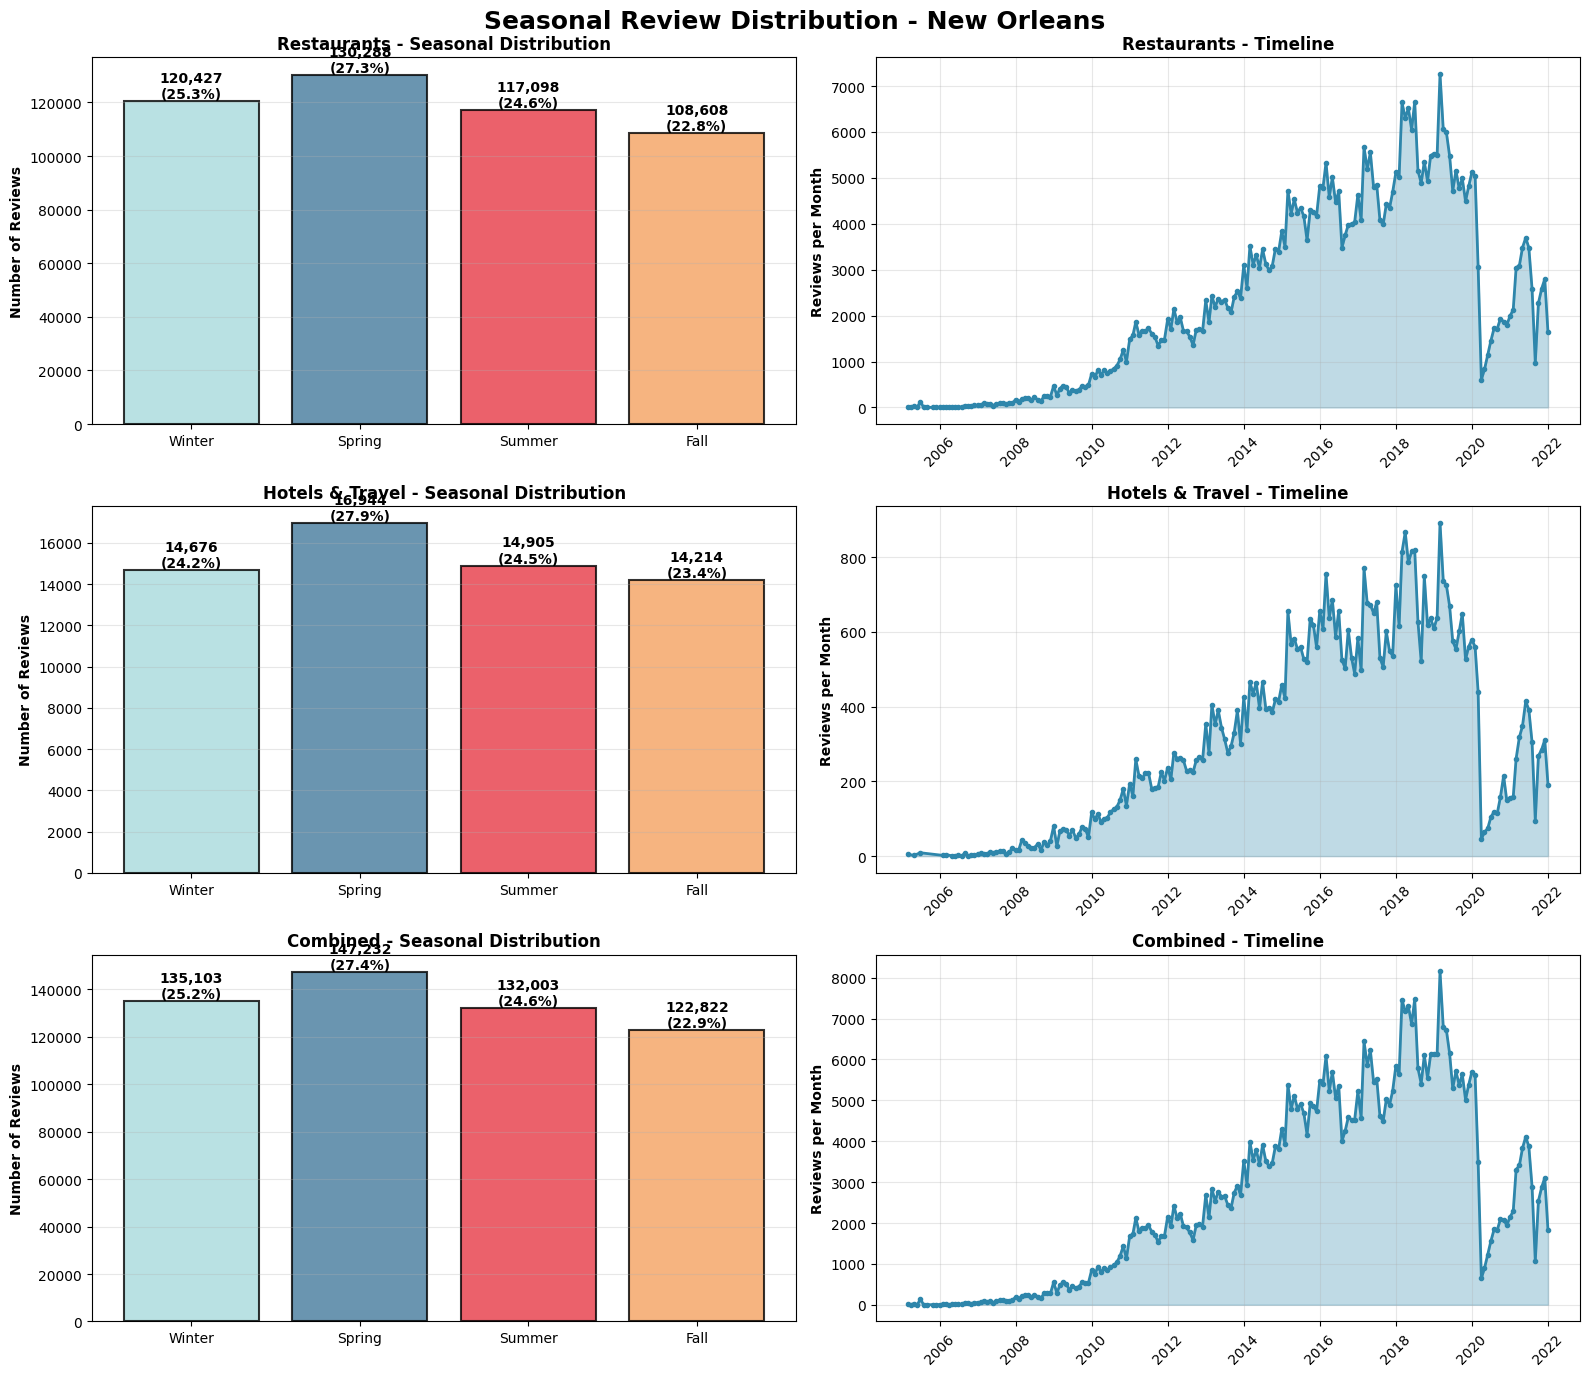


SEASONAL DISTRIBUTION ANALYSIS

RESTAURANTS
--------------------------------------------------------------------------------
  Winter  : 120,427 reviews ( 25.3%)
  Spring  : 130,288 reviews ( 27.3%)
  Summer  : 117,098 reviews ( 24.6%)
  Fall    : 108,608 reviews ( 22.8%)

  Total: 476,421 reviews
  Date range: 2005-03-14 to 2022-01-19
  Weakest season: Fall (22.8%)
  ✓ BALANCED: All seasons ≥15%

HOTELS & TRAVEL
--------------------------------------------------------------------------------
  Winter  : 14,676 reviews ( 24.2%)
  Spring  : 16,944 reviews ( 27.9%)
  Summer  : 14,905 reviews ( 24.5%)
  Fall    : 14,214 reviews ( 23.4%)

  Total: 60,739 reviews
  Date range: 2005-03-15 to 2022-01-19
  Weakest season: Fall (23.4%)
  ✓ BALANCED: All seasons ≥15%

COMBINED
--------------------------------------------------------------------------------
  Winter  : 135,103 reviews ( 25.2%)
  Spring  : 147,232 reviews ( 27.4%)
  Summer  : 132,003 reviews ( 24.6%)
  Fall    : 122,822 reviews (

In [22]:
import matplotlib.pyplot as plt
from datetime import datetime

def analyze_seasonal_distribution(review_file, business_ids_restaurants, business_ids_hotels, city_name):
    """
    Analyze review distribution by season for restaurants and hotels
    Only reads the REVIEW JSON file (business data already in CSV)
    """
    
    restaurants_reviews = []
    hotels_reviews = []
    
    print(f"Extracting reviews for {city_name}...")
    print(f"  Restaurants to check: {len(business_ids_restaurants)}")
    print(f"  Hotels to check: {len(business_ids_hotels)}")
    
    with open(review_file, 'r') as f:
        for i, line in enumerate(f):
            review = json.loads(line)
            business_id = review['business_id']
            
            if business_id in business_ids_restaurants:
                restaurants_reviews.append({
                    'date': review['date'],
                    'stars': review['stars'],
                    'category': 'Restaurants'
                })
            
            if business_id in business_ids_hotels:
                hotels_reviews.append({
                    'date': review['date'],
                    'stars': review['stars'],
                    'category': 'Hotels & Travel'
                })
            
            if (i + 1) % 500000 == 0:
                print(f"  Processed {i + 1:,} reviews... (Found {len(restaurants_reviews):,} restaurant + {len(hotels_reviews):,} hotel reviews)")
    
    # Combine into DataFrames
    df_restaurants = pd.DataFrame(restaurants_reviews)
    df_hotels = pd.DataFrame(hotels_reviews)
    df_combined = pd.concat([df_restaurants, df_hotels], ignore_index=True)
    
    print(f"\n✓ Found {len(df_restaurants):,} restaurant reviews")
    print(f"✓ Found {len(df_hotels):,} hotel reviews")
    print(f"✓ Total: {len(df_combined):,} reviews")
    
    # Convert dates
    for df in [df_restaurants, df_hotels, df_combined]:
        if len(df) > 0:
            df['date'] = pd.to_datetime(df['date'])
            df['month'] = df['date'].dt.month
            df['year'] = df['date'].dt.year
            df['year_month'] = df['date'].dt.to_period('M')
    
    return df_restaurants, df_hotels, df_combined


def visualize_seasonal_distribution(df_restaurants, df_hotels, df_combined, city_name):
    """
    Create three visualizations: restaurants, hotels, and combined
    """
    
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'
    
    # Add season column
    for df in [df_restaurants, df_hotels, df_combined]:
        if len(df) > 0:
            df['season'] = df['month'].apply(get_season)
    
    # Create figure with 3x2 grid
    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    fig.suptitle(f'Seasonal Review Distribution - {city_name}', fontsize=18, fontweight='bold')
    
    season_order = ['Winter', 'Spring', 'Summer', 'Fall']
    colors = ['#A8DADC', '#457B9D', '#E63946', '#F4A261']
    
    datasets = [
        (df_restaurants, 'Restaurants', 0),
        (df_hotels, 'Hotels & Travel', 1),
        (df_combined, 'Combined', 2)
    ]
    
    for df, label, row in datasets:
        if len(df) == 0:
            axes[row, 0].text(0.5, 0.5, f'No {label} data', 
                            ha='center', va='center', fontsize=14)
            axes[row, 1].text(0.5, 0.5, f'No {label} data', 
                            ha='center', va='center', fontsize=14)
            continue
        
        # Left column: Seasonal bar chart
        season_counts = df['season'].value_counts()[season_order]
        total = season_counts.sum()
        
        bars = axes[row, 0].bar(season_counts.index, season_counts.values, 
                                color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        axes[row, 0].set_title(f'{label} - Seasonal Distribution', fontweight='bold', fontsize=12)
        axes[row, 0].set_ylabel('Number of Reviews', fontweight='bold')
        axes[row, 0].grid(True, alpha=0.3, axis='y')
        
        # Add percentage labels on bars
        for i, (season, count) in enumerate(season_counts.items()):
            pct = (count / total) * 100
            axes[row, 0].text(i, count, f'{count:,}\n({pct:.1f}%)', 
                            ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Right column: Timeline
        monthly_counts = df.groupby('year_month').size()
        monthly_counts.index = monthly_counts.index.to_timestamp()
        
        axes[row, 1].plot(monthly_counts.index, monthly_counts.values, 
                         linewidth=2, color='#2E86AB', marker='o', markersize=3)
        axes[row, 1].fill_between(monthly_counts.index, monthly_counts.values, 
                                  alpha=0.3, color='#2E86AB')
        axes[row, 1].set_title(f'{label} - Timeline', fontweight='bold', fontsize=12)
        axes[row, 1].set_ylabel('Reviews per Month', fontweight='bold')
        axes[row, 1].grid(True, alpha=0.3)
        axes[row, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(f'{city_name.replace(" ", "_")}_seasonal_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\n" + "="*80)
    print("SEASONAL DISTRIBUTION ANALYSIS")
    print("="*80)
    
    for df, label in [(df_restaurants, 'RESTAURANTS'), 
                      (df_hotels, 'HOTELS & TRAVEL'), 
                      (df_combined, 'COMBINED')]:
        if len(df) == 0:
            continue
            
        print(f"\n{label}")
        print("-" * 80)
        
        season_counts = df['season'].value_counts()[season_order]
        total = season_counts.sum()
        
        for season in season_order:
            count = season_counts[season]
            pct = (count / total) * 100
            print(f"  {season:8s}: {count:6,} reviews ({pct:5.1f}%)")
        
        min_season = season_counts.idxmin()
        min_count = season_counts.min()
        min_pct = (min_count / total) * 100
        
        print(f"\n  Total: {total:,} reviews")
        print(f"  Date range: {df['date'].min().date()} to {df['date'].max().date()}")
        print(f"  Weakest season: {min_season} ({min_pct:.1f}%)")
        
        if min_pct >= 15:
            print(f"  ✓ BALANCED: All seasons ≥15%")
        else:
            print(f"  ✗ IMBALANCED: Weakest season <15%")


# Execute for New Orleans using the DataFrames we already have
business_ids_restaurants = set(df_nola_restaurants['business_id'])
business_ids_hotels = set(df_nola_hotels['business_id'])

# Extract reviews (this is the only part that reads JSON)
df_rest, df_hotels, df_comb = analyze_seasonal_distribution(
    '../data/raw/yelp_academic_dataset_review.json',
    business_ids_restaurants,
    business_ids_hotels,
    'New Orleans'
)

# Create visualizations
visualize_seasonal_distribution(df_rest, df_hotels, df_comb, 'New Orleans')

In [23]:
def check_dataset_date_range(review_file):
    """Check the overall date range of the entire review dataset"""
    
    min_date = None
    max_date = None
    total_reviews = 0
    
    print("Scanning entire review dataset for date range...")
    print("(This will take a few minutes)")
    
    with open(review_file, 'r') as f:
        for i, line in enumerate(f):
            review = json.loads(line)
            date = review['date']
            
            if min_date is None or date < min_date:
                min_date = date
            if max_date is None or date > max_date:
                max_date = date
            
            total_reviews += 1
            
            if (i + 1) % 1000000 == 0:
                print(f"  Processed {i + 1:,} reviews... (Current range: {min_date} to {max_date})")
    
    print("\n" + "="*70)
    print("ENTIRE YELP DATASET DATE RANGE")
    print("="*70)
    print(f"Earliest review: {min_date}")
    print(f"Latest review:   {max_date}")
    print(f"Total reviews:   {total_reviews:,}")
    print("="*70)

# Run it
check_dataset_date_range('../data/raw/yelp_academic_dataset_review.json')

Scanning entire review dataset for date range...
(This will take a few minutes)
  Processed 1,000,000 reviews... (Current range: 2005-03-01 17:47:15 to 2022-01-19 19:47:59)
  Processed 2,000,000 reviews... (Current range: 2005-03-01 16:57:17 to 2022-01-19 19:47:59)
  Processed 3,000,000 reviews... (Current range: 2005-03-01 16:57:17 to 2022-01-19 19:48:16)
  Processed 4,000,000 reviews... (Current range: 2005-03-01 16:57:17 to 2022-01-19 19:48:16)
  Processed 5,000,000 reviews... (Current range: 2005-02-16 03:23:22 to 2022-01-19 19:48:45)
  Processed 6,000,000 reviews... (Current range: 2005-02-16 03:23:22 to 2022-01-19 19:48:45)

ENTIRE YELP DATASET DATE RANGE
Earliest review: 2005-02-16 03:23:22
Latest review:   2022-01-19 19:48:45
Total reviews:   6,990,280
